In [1]:
# Als je `import clusterizer` typt, dan zoekt Python naar mappen en .py-bestanden met die naam.
# De plekken waar python gaat zoeken staan in de lijst `sys.path`.
# Omdat we nu in SCG-analyse/notebooks zitten, moeten we de bovenliggende map (`SCG-analyse`)
# toevoegen aan de lijst van zoekplekken.
import sys
if "../.." not in sys.path:
    sys.path.append("../..")

# Hiermee wordt de clusterizer module herladen wanneer een bestand ervan verandert
# (handig als je aan de module aan het werken bent).
# Als je dit niet doet, wordt de code (zoals circuit.py, plot.py, etc) alleen geladen wanneer
# je `import clusterizer` typt. 
%load_ext autoreload
%autoreload 2


import clusterizer

import matplotlib.pyplot as plt

# Nodig om een np.datetime64 tijdstip (zoals in de partial_discharges DataFrame) 
# als ascoordinaat te gebruiken.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Hogere DPI voor plotjes (is mooi)
%config InlineBackend.figure_format = 'retina'
# Standaard grootte van plotjes in inches
plt.rcParams['figure.figsize'] = [8, 5]

import pandas as pd
import numpy as np

Git root path found at: C:\dev\py\SCG-analyse
Using data path:        C:\dev\py\SCG-analyse\data\origineel


In [28]:
circuitnr = clusterizer.globals.available_circuits[1]


circuitje=clusterizer.circuit.MergedCircuit(circuitnr)
circuitje.build()

pr = "poisson_plots_2d_circuit_{}_".format(circuitnr)
pr

'poisson_plots_2d_circuit_3010_'

<IPython.core.display.Javascript object>


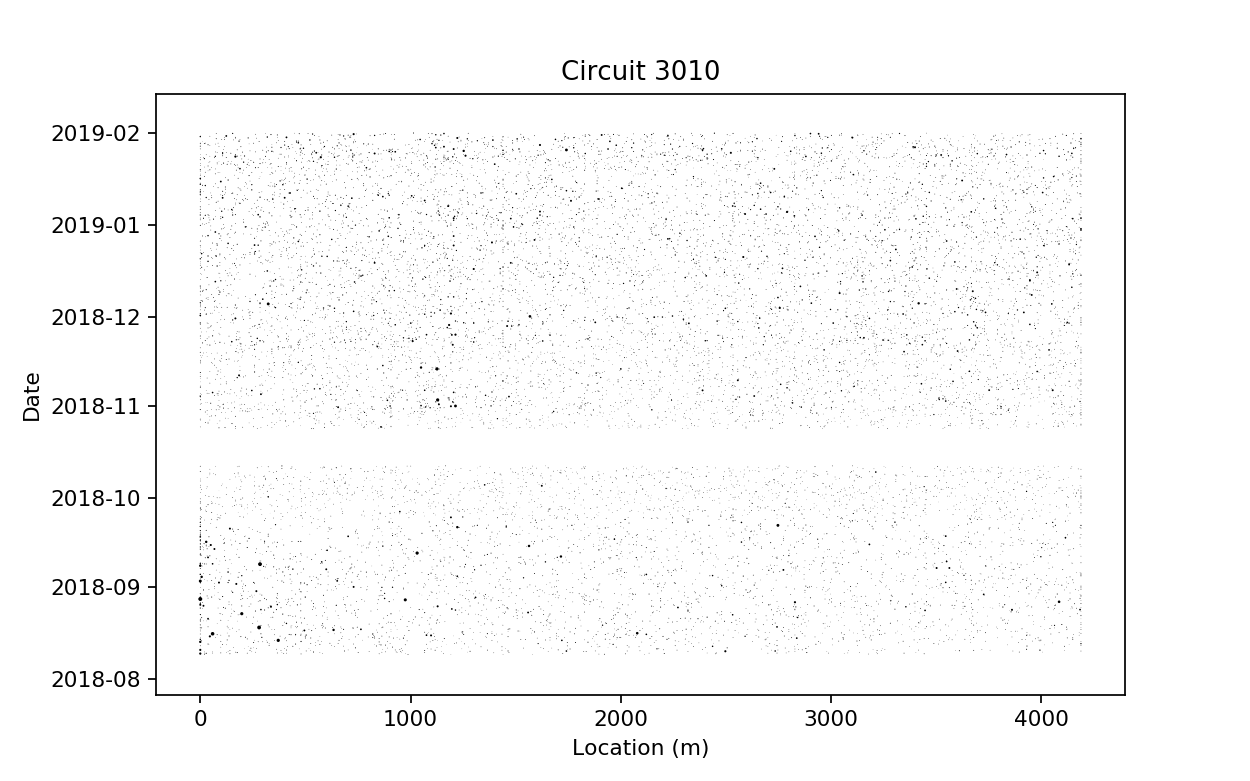

Saved to C:/dev/py/SCG-analyse/notebooks/plots/laagdpi.pdf


In [48]:
%matplotlib notebook

fig, ax = plt.subplots()

clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)

clusterizer.plot.save_figure_for_latex("laagdpi",dpi=50)

# Vinden van absoluut-geen-cluster gebieden: _nusters_

Dit doen we met een aantal stappen:
1. Discretiseer locatie
1. Identificeer de locaties waarop PD-gedrag nominaal is (laagste 80%)
1. Clusteriseer dat om een lijst _nusters_ te vinden



In [30]:
# --- PARAMETERS ---
bin_size = 4
weigh_charges = False
nominal_circuit_fraction = .80

time_bin_size = np.timedelta64('7','D')

In [31]:
locations = circuitje.pd["Location in meters (m)"][circuitje.pd_occured]
times = circuitje.pd["Date/time (UTC)"][circuitje.pd_occured]
charges = circuitje.pd["Charge (picocoulomb)"][circuitje.pd_occured]

In [32]:
bins = np.arange(start=0., stop=circuitje.circuitlength+bin_size, step=bin_size)
bin_contents, _ = np.histogram(locations, bins=bins, weights=charges if weigh_charges else None)

In [33]:
nominal_pd_quantile_level = np.sort(bin_contents)[int(nominal_circuit_fraction * len(bin_contents))]

is_below_quantile = bin_contents < nominal_pd_quantile_level

<IPython.core.display.Javascript object>


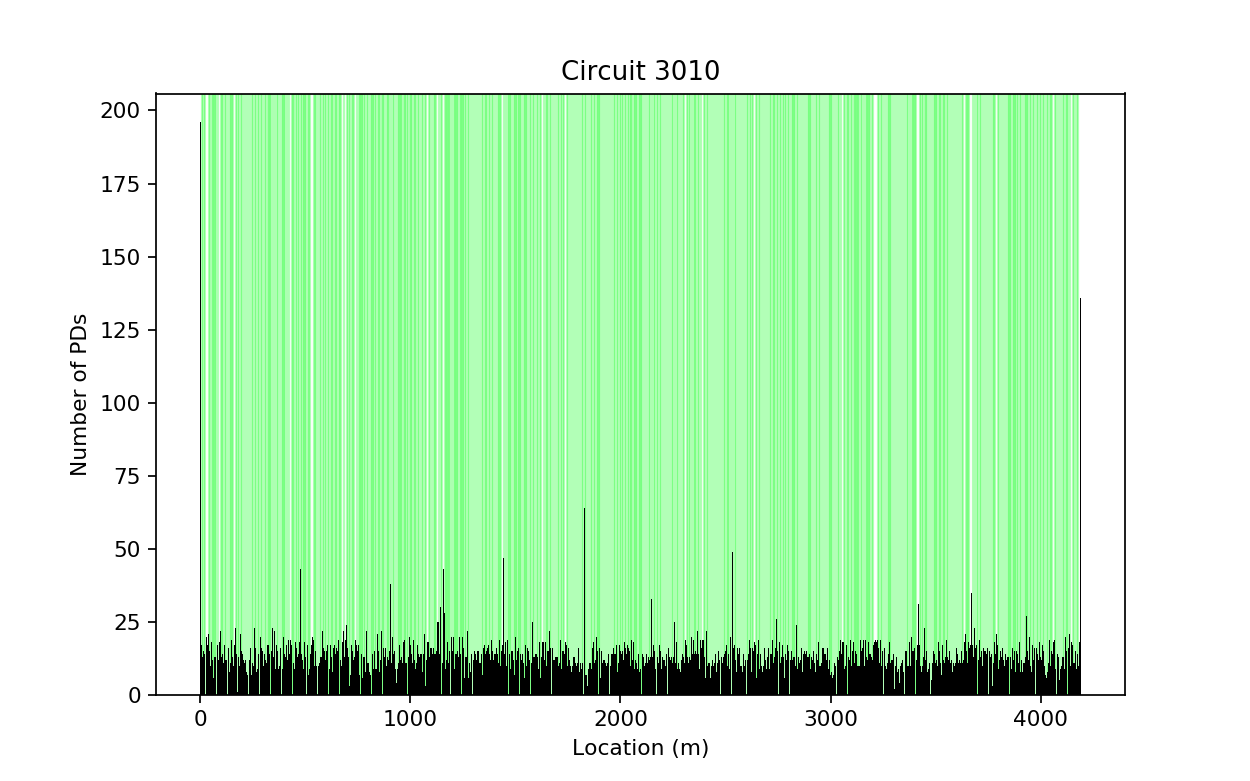

Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_A.png
Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_A.pdf


In [34]:
fig, ax = plt.subplots()

clusterizer.plot.draw_location_hist(circuitje, ax=ax, bins=bins)
clusterizer.plot.overlay_boolean_series(is_below_quantile, loc=bins[:-1], color="#00ff11")


clusterizer.plot.save_figure_for_google_slides(pr+"A")
clusterizer.plot.save_figure_for_latex(pr+"A")

## Clusteriseren van nominale stukken

In [35]:
below_quantile_groups = clusterizer.algorithms.group_boolean_series(is_below_quantile)
not_cluster_ranges = [np.array(g)*bin_size for g in below_quantile_groups]
not_cluster_ranges

[array([   0, 4184])]

<IPython.core.display.Javascript object>


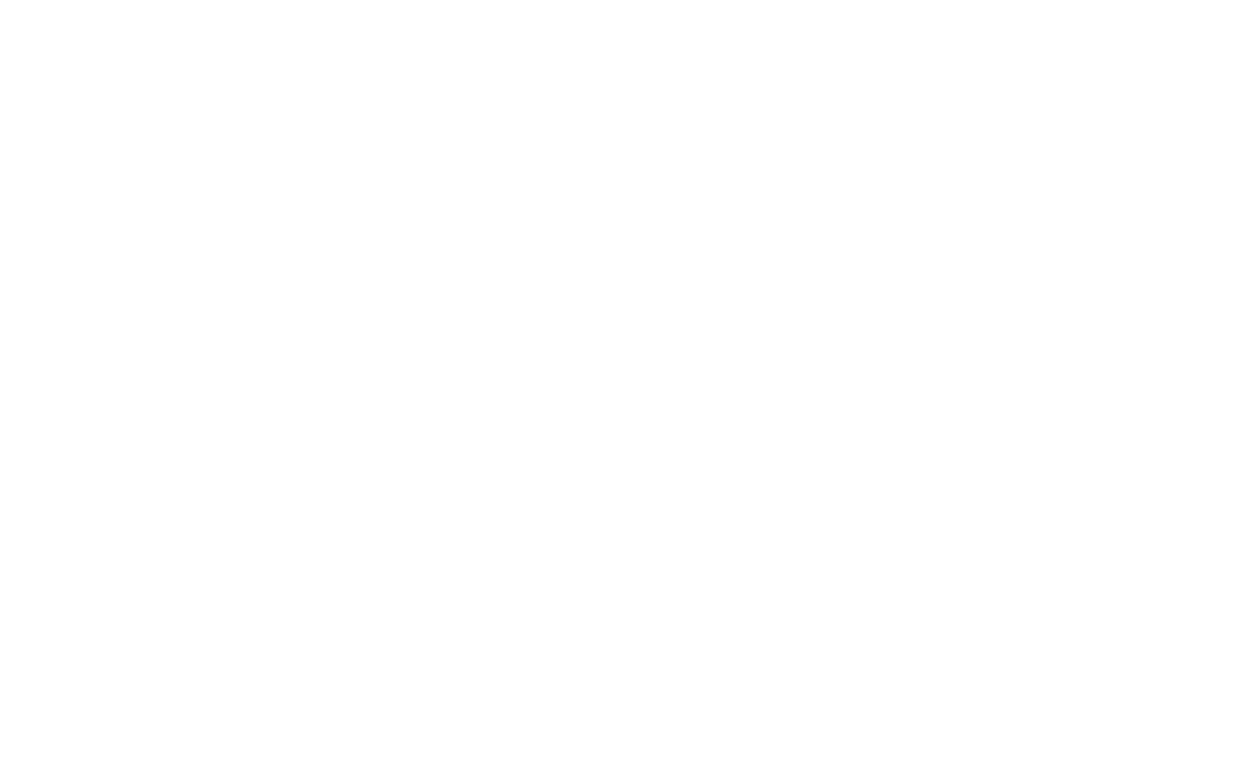

Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_B.png
Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_B.pdf


In [36]:
fig, ax = plt.subplots()

clusterizer.plot.draw_location_hist(circuitje, ax=ax, bins=bins)

for i, r in enumerate(not_cluster_ranges):
    not_a_cluster = clusterizer.rectangle.Rectangle(location_range=r)
    clusterizer.plot.overlay_rectangle(not_a_cluster, ax=ax, label="nuster {}".format(i+1), color="green")
ax.legend()

clusterizer.plot.save_figure_for_google_slides(pr+"B")
clusterizer.plot.save_figure_for_latex(pr+"B")

# En nu?

Wanneer we een cluster hebben gevonden in locatie, kan dit helpen met het vinden van de begin- en eindtijd. We kunnen de nusters namelijk gebruiken als 'context': het geeft voor elk tijdstip aan wat nominaal PD-gedrag op dat tijdstip is.

----

We willen een lijst van bools, die van elke PD aangeeft of deze wel of niet in een nuster zit:

In [37]:
# Dit is niet bedoeld om leesbaar te zijn
import functools

which_inside_location_range = lambda location_range: np.logical_and(location_range[0] < locations.values, locations.values < location_range[1])

#in_a_nuster = functools.reduce(np.logical_or, (are_inside_location_range(locations.values, nr) for nr in not_cluster_ranges))
in_a_nuster = functools.reduce(np.logical_or, map(which_inside_location_range, not_cluster_ranges))

# Maar het geeft:

# in_a_nuster is een np.array van booleans, dat even lang is als het aantal PDs.

# in_a_nuster[i] == True 
#    desda
# de PD nummer i zit in een van de nusters (blauwe gebieden in de vorige plot)

<IPython.core.display.Javascript object>


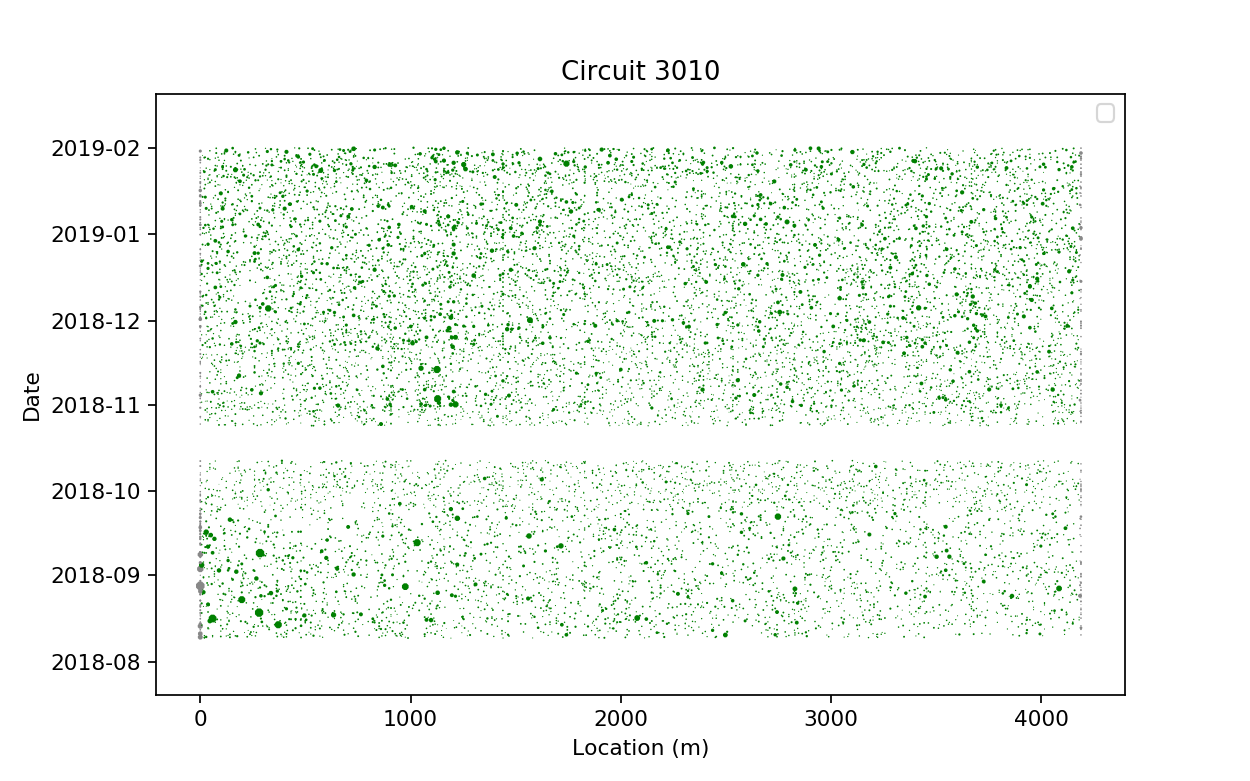

No handles with labels found to put in legend.


In [39]:
fig, ax = plt.subplots()


nuster_pds = circuitje.pd[circuitje.pd_occured][in_a_nuster]

colors = ["green" if n else "#888888" for n in in_a_nuster]

#clusterizer.plot.draw_location_time_scatter(circuitje)
clusterizer.plot.draw_location_time_scatter(circuitje, dot_size_to_charge_ratio=1e3, dot_colors=colors)
#ax.scatter(nuster_pds["Location in meters (m)"], nuster_pds["Date/time (UTC)"], c="green", s=1, label="in a nuster")

ax.legend()

## Toepassen 🐟-model
Dit geeft ons clusters, maar alleen in locatie.

In [40]:
loc_clusters, loc_bins, loc_bin_contents, nominal_pd_quantile_level, rate, fault_pd_level = clusterizer.algorithms.clusterize_poisson_1d(circuitje, loc_bin_size=bin_size, weigh_charges=weigh_charges, nominal_circuit_fraction=nominal_circuit_fraction, return_intermediate_values=True)

favourite_cluster = sorted(list(loc_clusters))[3]
favourite_cluster

IndexError: list index out of range

<IPython.core.display.Javascript object>


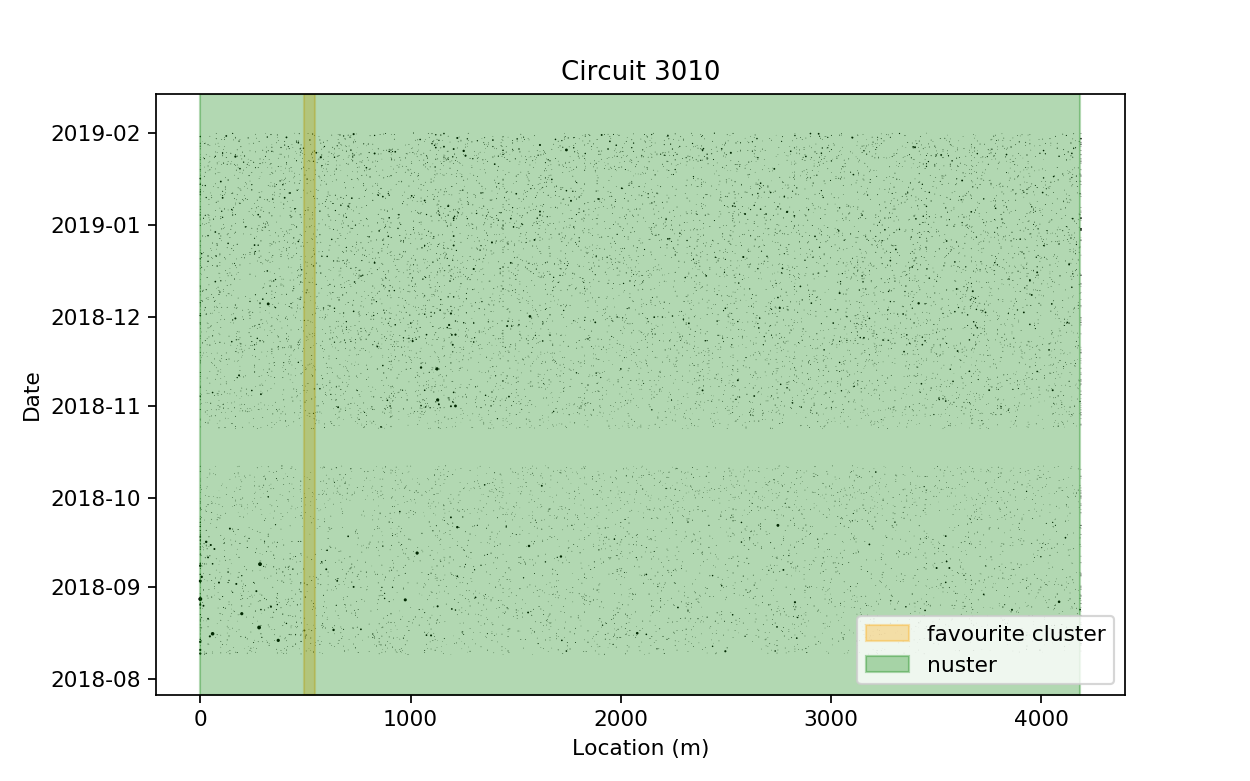

Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_C.png
Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_C.pdf


In [41]:
fig, ax = plt.subplots()

clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)
clusterizer.plot.overlay_rectangle(favourite_cluster, ax=ax, color='orange', label="favourite cluster")

for i, r in enumerate(not_cluster_ranges):
    not_a_cluster = clusterizer.rectangle.Rectangle(location_range=r)
    clusterizer.plot.overlay_rectangle(not_a_cluster, ax=ax, label="nuster", color="green")

clusterizer.plot.legend_without_duplicate_labels()

clusterizer.plot.save_figure_for_google_slides(pr+"C")
clusterizer.plot.save_figure_for_latex(pr+"C")

We kunnen nu twee tijdshistogrammen maken: eentje van alle PDs in ons favoriete cluster, en eentje van alle PDs in de nusters.

**De verhouding tussen deze twee reeksen geeft aan hoe bijzonder hoog het aantal PDs binnen het cluster is.**

Als er in ons favoriete "cluster" eigenlijk niks aan de hand is, dan zou deze verhouding moeten zijn:

$$\frac{\text{(ruisdichtheid)} \cdot \text{(lengte_tijd_bakje)} \cdot \text{(breedte_cluster)}}{\text{(ruisdichtheid)} \cdot \text{(lengte_tijd_bakje)} \cdot \sum_{\text{nuster}}\text{(breedte_nuster)}} = \frac{\text{(breedte_cluster)}}{\sum_{\text{nuster}}\text{(breedte_nuster)}}$$


In [42]:
times_in_nuster = times[in_a_nuster]

<IPython.core.display.Javascript object>


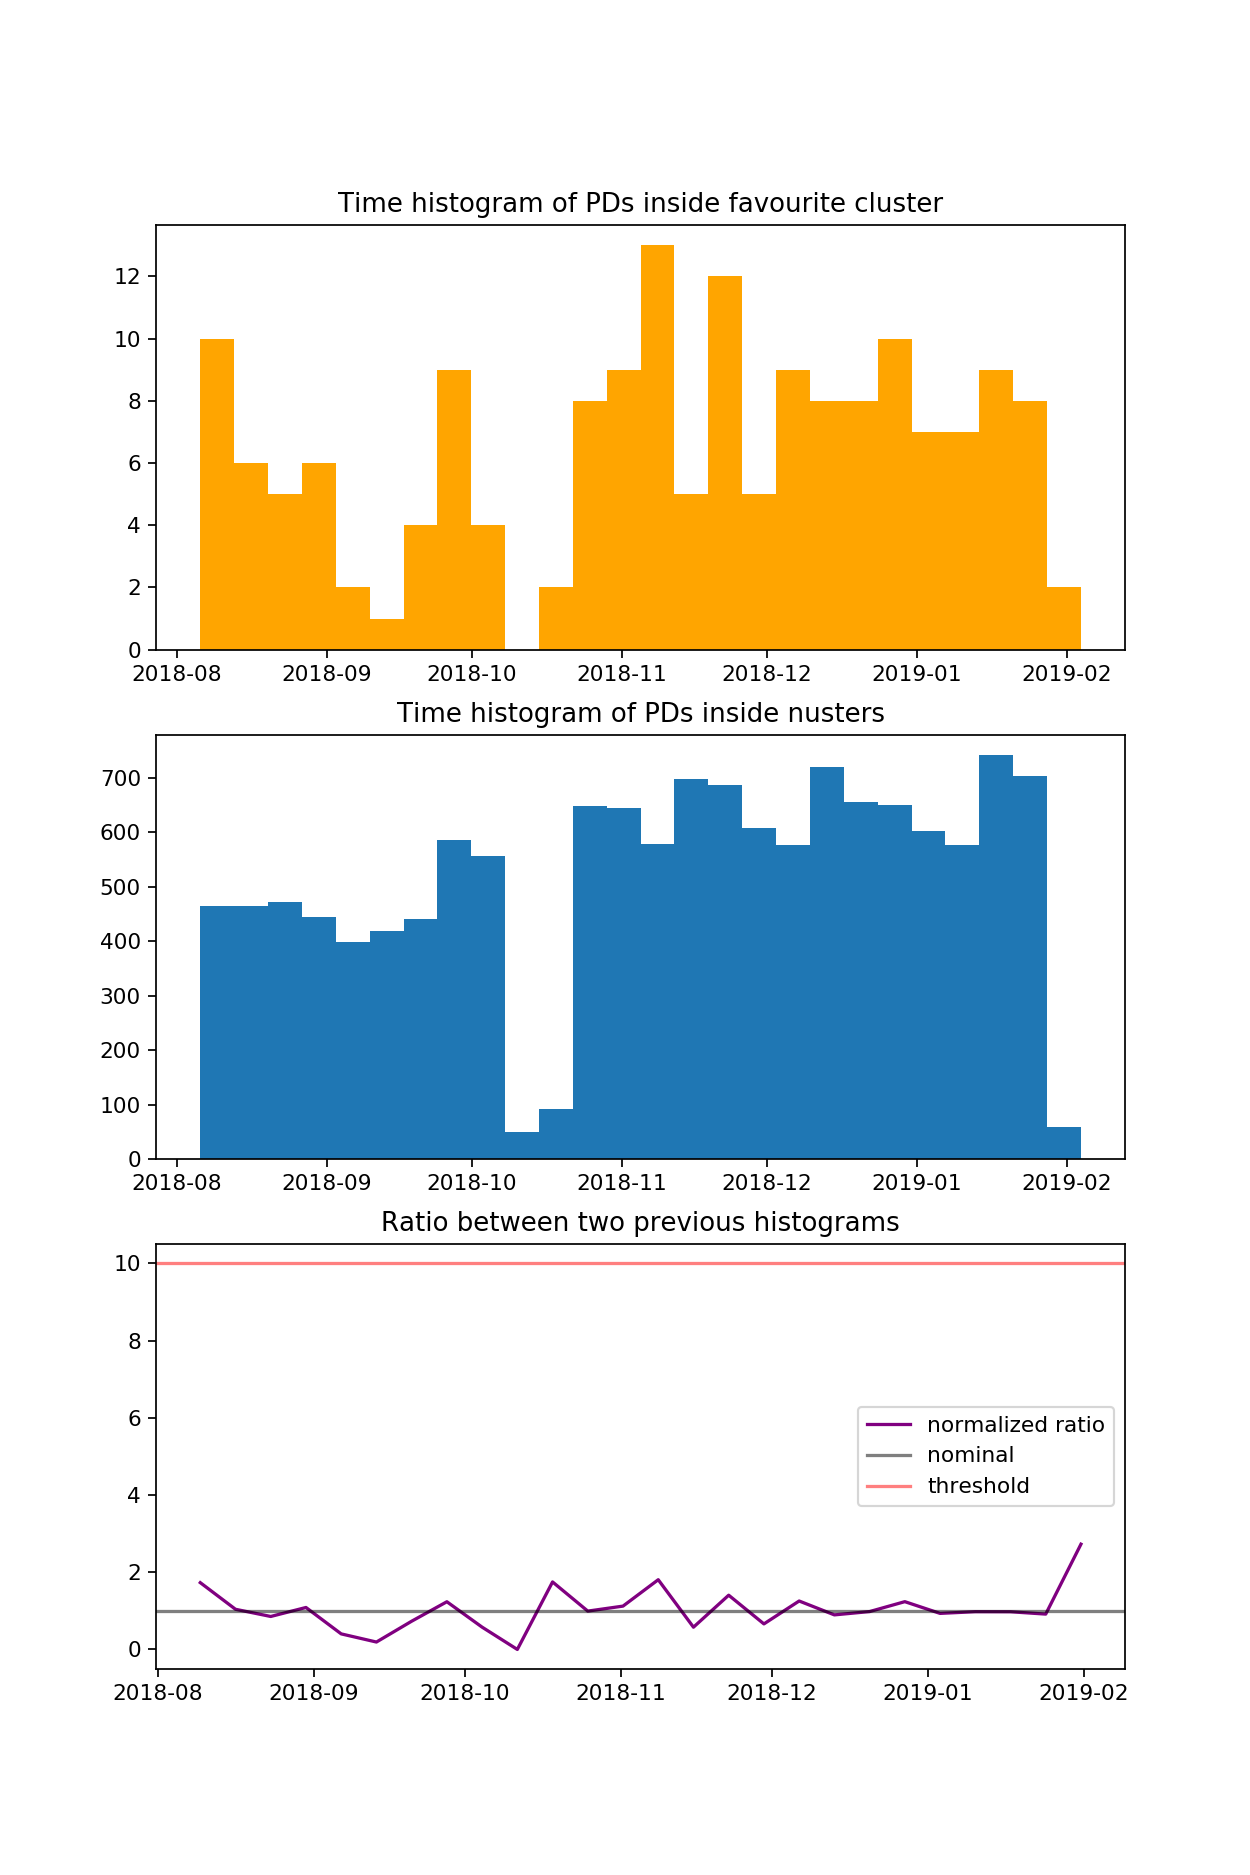

Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_D.png
Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_D.pdf


In [43]:
fig, ax = plt.subplots(3,1,figsize=(8,12))

time_bins = np.arange(min(times), max(times)+time_bin_size, time_bin_size)

clust_counts, _ = np.histogram(times[which_inside_location_range(favourite_cluster.location_range)], bins=time_bins)
nust_counts, _ = np.histogram(times_in_nuster, bins=time_bins)

ax[0].bar(time_bins[:-1], clust_counts, width=7.0, color="orange")
ax[0].set_title("Time histogram of PDs inside favourite cluster")
ax[1].bar(time_bins[:-1], nust_counts, width=7.0)
ax[1].set_title("Time histogram of PDs inside nusters")

total_nuster_length = sum(b - a for a, b in not_cluster_ranges)
cluster_length = favourite_cluster.get_width()
nominal_ratio = cluster_length / total_nuster_length

ax[2].plot(time_bins[:-1], clust_counts/nust_counts/nominal_ratio, c='purple', label='normalized ratio')
ax[2].axhline(1, c='0', alpha=.5, label='nominal')
ax[2].axhline(10, c='r', alpha=.5, label='threshold')
ax[2].set_title("Ratio between two previous histograms")
ax[2].legend()


clusterizer.plot.save_figure_for_google_slides(pr+"D", reset_size=False)
clusterizer.plot.save_figure_for_latex(pr+"D", reset_size=False)

Ik heb 10 vingers, dus dit lijkt me een goede threshold voor de verhouding (PDs binnen cluster / PDs binnen nusters)

In [44]:
magic_ratio = 10

found_2d_clusters = set()

is_suspiciously_high_ratio = clust_counts/nust_counts/nominal_ratio > magic_ratio

for a,b in clusterizer.algorithms.group_boolean_series(is_suspiciously_high_ratio, max_consecutive_false=1, min_length=0, min_count=2):
    tr = (time_bins[a], time_bins[b])
    r = clusterizer.rectangle.Rectangle(location_range=favourite_cluster.location_range, time_range=tr, found_by=["Poisson 2D"])
    found_2d_clusters.add(clusterizer.cluster.Cluster({r}))

found_2d_clusters

set()

<IPython.core.display.Javascript object>


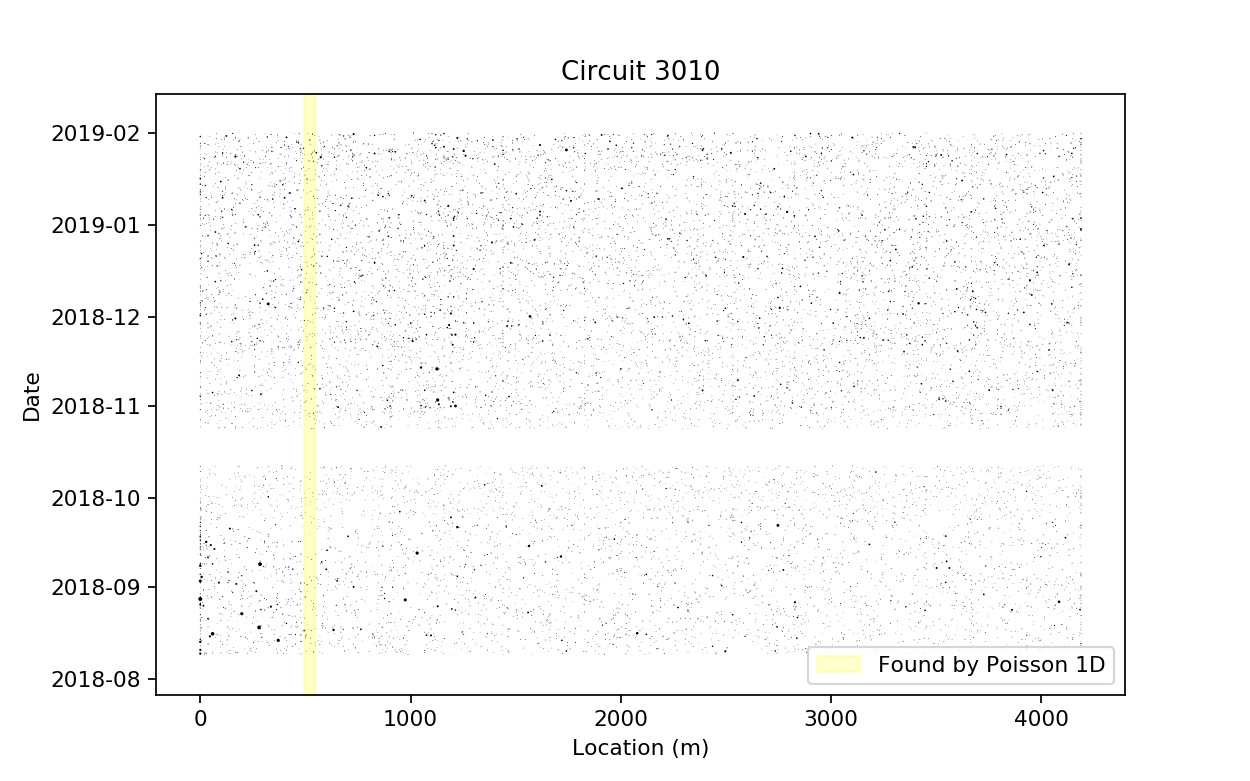

Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_E.png
Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_E.pdf


In [45]:
fig, ax = plt.subplots()

clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)
clusterizer.plot.overlay_cluster(favourite_cluster, ax=ax, color="yellow", opacity=.2)
clusterizer.plot.overlay_cluster_ensemble(found_2d_clusters, ax=ax, color="red", opacity=.7)
clusterizer.plot.legend_without_duplicate_labels()


clusterizer.plot.save_figure_for_google_slides(pr+"E")
clusterizer.plot.save_figure_for_latex(pr+"E")

# Samengevat
We kunnen dit voor elke locatie-cluster doen:

In [46]:
%%time

times_in_nuster = times[in_a_nuster]

total_nuster_length = sum(b - a for a, b in not_cluster_ranges)

time_bins = np.arange(min(times), max(times)+time_bin_size, time_bin_size)
nust_counts, _ = np.histogram(times_in_nuster, bins=time_bins)

found_2d_clusters = set()

for loc_cluster in loc_clusters:
    clust_counts, _ = np.histogram(times[which_inside_location_range(loc_cluster.location_range)], bins=time_bins)
    cluster_length = loc_cluster.get_width()
    nominal_ratio = cluster_length / total_nuster_length

    is_suspiciously_high_ratio = clust_counts/nust_counts/nominal_ratio > magic_ratio

    for a,b in clusterizer.algorithms.group_boolean_series(is_suspiciously_high_ratio, max_consecutive_false=1, min_length=0, min_count=2):
        tr = (time_bins[a], time_bins[b])
        r = clusterizer.rectangle.Rectangle(location_range=loc_cluster.location_range, time_range=tr, found_by=["Poisson 2D"])
        found_2d_clusters.add(clusterizer.cluster.Cluster({r}))

Wall time: 203 ms


<IPython.core.display.Javascript object>


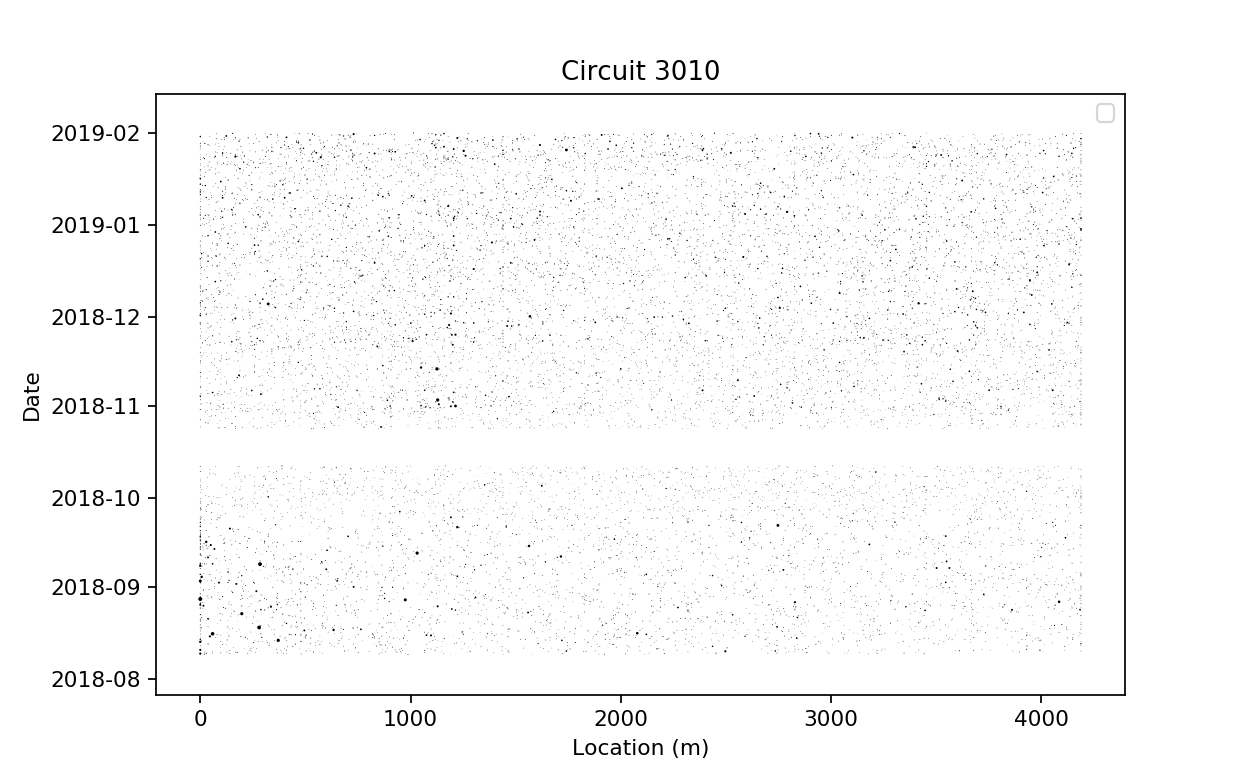

No handles with labels found to put in legend.


Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_F.png
Saved to C:/dev/py/SCG-analyse/notebooks/plots/poisson_plots_2d_circuit_3010_F.pdf


In [47]:
fig, ax = plt.subplots()

clusterizer.plot.draw_location_time_scatter(circuitje, ax=ax)
clusterizer.plot.overlay_cluster_ensemble(loc_clusters, ax=ax, color="yellow", opacity=.2)
clusterizer.plot.overlay_cluster_ensemble(found_2d_clusters, ax=ax, color="red", opacity=.7)
clusterizer.plot.legend_without_duplicate_labels()


clusterizer.plot.save_figure_for_google_slides(pr+"F")
clusterizer.plot.save_figure_for_latex(pr+"F")